# 행동 스티커 만들기
- MPII Human Pose Datasset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련 프로젝트

In [1]:
## 명령어를 통해 클라우드에 미리 다운되어 있는 데이터를 링크를 걸어서 압축을 해제하여 실습을 진행함.

# $ mkdir -p ~/aiffel/mpii
# $ ln -s ~/data/* ~/aiffel/mpii
# $ cd ~/aiffel/mpii
# $ tar -xvf mpii_human_pose_v1.tar.gz -C . #압축 해제 부분
# $ unzip mpii_human_pose_v1_u12_2.zip


## json 파일로 변환된 파일
# $ cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
# $ wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
# $ wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json

## 실습코드
# $ cd ~/aiffel/mpii && unzip mpii.zip

In [3]:
!pip list | grep loguru

loguru                        0.5.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
! pip list | grep ray

ray                           1.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 데이터 전처리

### tfrecords 파일 생성
- tfrecord 는 binary record sequence 를 저장하기 위한 형식임.
- 학습 속도를 향상시키기 위해 데이터 관점에서 고려해야하는 단계는 data read(또는 prefetch) 또는 데이터 변환 단계. gpu 학습과 병렬적으로 수행되도록 prefetch를 적용하는 것임.
- 수행 방법은 tf.data의 map 함수를 이용하고 cache 에 저장해두는 방법.
- 데이터셋을 tfrecord 형태로 표현하는 것.

In [5]:
#tfrecords_mpii.py 라는 이름으로 파일을 생성
#이후 데이터 전처리 과정을 거쳐 tfrecord 파일을 생성하는 작업을 진행

import csv
import io
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #CPU 사용
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

workdir = os.path.join(os.getenv('HOME'),'aiffel/mpii')
os.chdir(workdir)

from loguru import logger
from PIL import Image
import ray
import tensorflow as tf

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')

2021-12-14 11:14:27,888	WARNING utils.py:480 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2021-12-14 11:14:28,379	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-14 11:14:28,383	WARNING services.py:1640 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


### json 파싱하기

In [6]:
#train.json과 validation.json 파일은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 Pose Estimation을 위한 label로 삼을 수 있음.
#json 파일 구성 확인 위해 annotation 정보를 1개만 출력.
#json.dumps()를 활용해서 좀 더 명확하게 하면 좋음.

import json, os

json_file_path = os.getenv('HOME')+'/aiffel/mpii/mpii_human_pose_v1_u12_2/train.json'

with open(json_file_path) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2) # json beautify
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


- joints 가 label 로 사용할 keypoint 의 label임.
- 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에 joints_vis 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냄.
- MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있음.
- coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있음.
- scale 정보가 coco dataset에는 scale 값 또한 2차원으로 주어져서 bbox scale 이 나오지만 mpii 는 높이만 나옴.

### joints 순서
- 0 - 오른쪽 발목
- 1 - 오른쪽 무릎
- 2 - 오른쪽 엉덩이
- 3 - 왼쪽 엉덩이
- 4 - 왼쪽 무릎
- 5 - 왼쪽 발목
- 6 - 골반
- 7 - 가슴(흉부)
- 8 - 목
- 9 - 머리 위
- 10 - 오른쪽 손목
- 11 - 오른쪽 팔꿈치
- 12 - 오른쪽 어깨
- 13 - 왼쪽 어깨
- 14 - 왼쪽 팔꿈치
- 15 - 왼쪽 손목

In [7]:
#json annotation 파싱하는 함수
#image 의 전체 path 를 묶어 dict 타입의 label 로 만듦.
#이 label 을 가지고 학습을 진행함. 

def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

- tfrecord로 데이터셋을 변환하기 위해 내부적으로 protocol buffer를 이용함.
- protobuf 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리임.

In [8]:
import ray

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

- annotation 을 total_shards 개수로 나눔(chunkify) (train : 64개, val : 8개)
- build_single_tfrecord 함수를 통해 tfrecord 로 저장
- 각 chunk 끼리 dependency 가 없기 때문에 병렬처리가 가능, ray를 사용

In [9]:
#annotation을 적절한 개수로 나누는 함수
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results

- l 은 annotation, n은 shard 개수, shard 개수 단위로 annotation list 를 나누어서 새로운 list를 생성함.
- (size, shard, anno_content) 와 같은 꼴을 가질 것.

In [10]:
#tfrecord 1개를 저장하는 함수

@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = genreate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

- TFRecordWriter 를 이용해서 anno_list 를 shard 개수 단위로 작성하고 generate_tfexample 함수를 사용함.
- write 할 때 string 으로 serialize 해야함!

In [11]:
#tf.example 생성
def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

- 정의한 json 의 python type의 값들을 tfexample 에 사용할 수 있는 값으로 변환.
- image 파일은 byte 로 변환하는데 bitmap 으로 저장하게 되면 파일 용량이 상당히 커지기 때문에 만약 jpeg 타입이 아닌 경우 jpeg 으로 변환 후 content 로 불러서 저장함. (H,W,C)
- 각 label 값을 tf.train.Feature 로 저장.(데이터 타입 주의)
- 이미지는 byte 인코딩 된 값을 그대로 넣음.

In [12]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

## Ray
- Ray 는 파이썬을 위한 간단한 분산 애플리케이션 api임.
- MP 는 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 ray 는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있음.

In [13]:
# tfrecords_mpii.py 코드 내용

import csv
import io
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from loguru import logger
from PIL import Image
import ray
import tensorflow as tf

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')


def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    # x = [
    #     joint[0] / width if joint[0] >= 0 else joint[0]
    #     for joint in anno['joints']
    # ]
    # y = [
    #     joint[1] / height if joint[1] >= 0 else joint[0]
    #     for joint in anno['joints']
    # ]
    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        # 'image/object/parts/x':
        # tf.train.Feature(float_list=tf.train.FloatList(value=x)),
        # 'image/object/parts/y':
        # tf.train.Feature(float_list=tf.train.FloatList(value=y)),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = generate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)


def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation


def main():
    print('Start to parse annotations.')
    if not os.path.exists('./tfrecords_mpii'):
        os.makedirs('./tfrecords_mpii')

    with open('./mpii_human_pose_v1_u12_2/train.json') as train_json:
        train_annos = json.load(train_json)
        train_annotations = [
            parse_one_annotation(anno, './images/')
            for anno in train_annos
        ]
        print('First train annotation: ', train_annotations[0])
        del (train_annos)

    with open('./mpii_human_pose_v1_u12_2/validation.json') as val_json:
        val_annos = json.load(val_json)
        val_annotations = [
            parse_one_annotation(anno, './images/') for anno in val_annos
        ]
        print('First val annotation: ', val_annotations[0])
        del (val_annos)

    print('Start to build TF Records.')
    build_tf_records(train_annotations, num_train_shards, 'train')
    build_tf_records(val_annotations, num_val_shards, 'val')

    print('Successfully wrote {} annotations to TF Records.'.format(
        len(train_annotations) + len(val_annotations)))


if __name__ == '__main__':
    main()

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [14]:
# tfrecord 생성
! cd ~/aiffel/mpii && python tfrecords_mpii.py

2021-12-14 11:25:28,336	WARNING utils.py:480 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2021-12-14 11:25:28,903	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8266
2021-12-14 11:25:28,906	WARNING services.py:1640 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
Start to parse annotations.
First train annotation:  {'fil

(pid=353) finished building tf records for ./tfrecords_mpii/train_0030_of_0064.tfrecords
(pid=353) start to build tf records for ./tfrecords_mpii/train_0034_of_0064.tfrecords
(pid=354) finished building tf records for ./tfrecords_mpii/train_0032_of_0064.tfrecords
(pid=354) start to build tf records for ./tfrecords_mpii/train_0035_of_0064.tfrecords
(pid=351) finished building tf records for ./tfrecords_mpii/train_0031_of_0064.tfrecords
(pid=351) start to build tf records for ./tfrecords_mpii/train_0036_of_0064.tfrecords
(pid=352) finished building tf records for ./tfrecords_mpii/train_0033_of_0064.tfrecords
(pid=352) start to build tf records for ./tfrecords_mpii/train_0037_of_0064.tfrecords
(pid=353) finished building tf records for ./tfrecords_mpii/train_0034_of_0064.tfrecords
(pid=353) start to build tf records for ./tfrecords_mpii/train_0038_of_0064.tfrecords
(pid=354) finished building tf records for ./tfrecords_mpii/train_0035_of_0064.tfrecords
(pid=354) start to build tf records 

In [15]:
! cd ~/aiffel/mpii/tfrecords_mpii && ls | wc

     72      72    2072


## dataloader 생성
- tfrecords 파일을 읽고 전처리를 할 수 있는 dataloader 생성.
- preprocess.py 라는 이름으로 파일을 생성.

In [16]:
import tensorflow as tf

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

- tfrecord 파일이기 때문에 병렬로 읽는 것은 tf 가 지원함.
- self.parse_tfexample() 에 구현되어 있고 이 함수를 통해 tf.tensor 로 이루어진 dictionary 형태의 features를 얻을 수 있음.
- image 는 features['image/encoded'] 형태로 사용할 수 있고 tfrecord 를 저장할 때 jpeg encoding 된 값을 넣었으니 tf.io.decode_jpeg()로 decoding 하여 tensor 형태의 이미지를 얻음.
- crop_roi() 메소드를 이용해 해당 이미지를 학습하기 편하도록 트릭 사용함.
- make_heatmaps() 메소드를 이용해 label을 heatmap으로 보여줌.

In [17]:
def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'imaage/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)

- tfrecord 파일 형식을 저장한 data type feature 에 맞게 parsing함.
- tfrecord 에서 사용할 key 값들과 data type 을 모르면 tfrecord 파일을 사용하기 어려움.
- 이렇게 얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환함.

In [18]:
def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        # keypoint 중 유효한값(visible = 1) 만 사용합니다.
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        # min, max 값을 찾습니다.
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        # shift all keypoints based on the crop area
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y

- 알고 있는 것은 joints 의 위치, center 의 좌표, body height 값임.
- 일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요함.
- 높이 정보와 keypoint 위치를 이용해서 정사각형 박스를 사용하는 것을 기본으로 디자인함.
- 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 함.
- (x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경시킴.

In [19]:
def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

- 16개의 점을 generate_2d_gaussian() 함수를 이용해서 64x64 의 map 에 표현.

In [20]:
def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
        applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
        (with standard deviation of 1 px) centered on the keypoint location."

        https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
        """
        heatmap = tf.zeros((height, width))

        # this gaussian patch is 7x7, let's get four corners of it first
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        # if the patch is out of image boundary we simply return nothing according to the source code
        # [1]"In these cases the joint is either truncated or severely occluded, so for
        # supervision a ground truth heatmap of all zeros is provided."
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        # the center of the gaussian patch should be 1
        center_x = size // 2
        center_y = size // 2

        # generate this 7x7 gaussian patch
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # part of the patch could be out of the boundary, so we need to determine the valid range
        # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
        # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        # also, we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # finally, insert this patch into the heatmap
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap

- sigma 값이 1 이고 window size 7 인 필터를 이용해서 만듦.

In [21]:
#preprocess.py
#데이터를 읽는 모듈

import tensorflow as tf


class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
        applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
        (with standard deviation of 1 px) centered on the keypoint location."

        https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
        """
        heatmap = tf.zeros((height, width))

        # this gaussian patch is 7x7, let's get four corners of it first
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        # if the patch is out of image boundary we simply return nothing according to the source code
        # [1]"In these cases the joint is either truncated or severely occluded, so for
        # supervision a ground truth heatmap of all zeros is provided."
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        # the center of the gaussian patch should be 1
        center_x = size // 2
        center_y = size // 2

        # generate this 7x7 gaussian patch
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # part of the patch could be out of the boundary, so we need to determine the valid range
        # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
        # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        # also, we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # finally, insert this patch into the heatmap
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)

## Hourglass 모델 생성

In [22]:
import tensorflow as tf

from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

In [23]:
#Residual block module

def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [24]:
#Hourglass module

def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

- 바깥부터 5개의 양파껍질(층)을 만들려면 order 를 이용해서 5,4...1 이 될 때까지 HourglassModule 을 반복하면 order 가 1이 되면 BottleneckBlock 으로 대체하여 만듦.
- 이 hourglass 모듈을 여러 층으로 쌓은 것이 stacked hourglass network임.
- 모델이 깊어지는 만큼 학습이 어려워 intermediate loss (auxilary loss) 를 추가해야 함.

In [25]:
#intermediate output을 위한 linear layer

def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

- stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산함.
- 지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됨.

In [26]:
#Stacked Hourglass

def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

## 학습 엔진 만들기
- 학습 코드 구현.
- 앞서 만든 *.py 모듈들은 여기서 참조(import)되어 사용될 것.

In [27]:
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime

import click
import tensorflow as tf

from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

- model 로 만들어 둔 hourglass와 데이터 전처리용 preprocess 를 import함.

In [28]:
#gpu memory growth 옵션 조정
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [29]:
#학습 옵션

class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 version='0.0.1',
                 start_epoch=1,
                 tensorboard_dir='./logs'):
        self.start_epoch = start_epoch
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)

        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.tensorboard_dir = tensorboard_dir
        self.best_model = None
        self.version = version

- loss : MSE (heatmap 을 pixel 단위 MSE 로 계산)
- strategy : 분산학습용 tf.strategy. 사용 가능한 GPU가 1개뿐이라면 사용하지 않음.
- optimizer : Adam

In [32]:
#learning rate
#learning rate 는 decay step 에 따라 1/10 씩 작아지도록 설정

def lr_decay(self):
        """
        This effectively simulate ReduceOnPlateau learning rate schedule. Learning rate
        will be reduced by a factor of 5 if there's no improvement over [max_patience] epochs
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

def lr_decay_step(self, epoch):
    if epoch == 25 or epoch == 50 or epoch == 75:
        self.current_learning_rate /= 10.0
    self.optimizer.learning_rate = self.current_learning_rate

In [33]:
#loss function
def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            # assign more weights to foreground pixels
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

- 예측해야 하는 positive (joint 들) 의 비율이 negative (배경) 에 비해 상당히 적은 비율로 등장하기 때문에 self.loss_object 를 사용해서 MSE 로 구현하는 것이 맞지만 동일 weight MSE 는 수렴이 잘되지 않음.
- 때문에 실제 구현에서는 약간의 테크닉을 추가해 줘야함.
- label 이 배경이 아닌 경우 (heatmap 값이 0보다 큰 경우) 에 추가적인 weight 를 주면 보다 나아지는 경향을 볼 수 있었음.
- weight 가 82인 이유는 heatmap 전체 크기인 64x64 에서 gaussian point 등장 비율이 7x7 패치이기 때문임.(64 / 7 = 9.1 ⇒ 9x9 )

In [34]:
#tf.gradienttape 을 이용해 loss 를 업데이트 함.

def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

def val_step(self, inputs):
    images, labels = inputs
    outputs = self.model(images, training=False)
    loss = self.compute_loss(labels, outputs)
    return loss

In [39]:
#실제 학습하는 함수

def run(self, train_dist_dataset, val_dist_dataset):
    @tf.function
    def distributed_train_epoch(dataset):
        tf.print('Start distributed traininng...')
        total_loss = 0.0
        num_train_batches = 0.0
        for one_batch in dataset:
            per_replica_loss = self.strategy.run(
                self.train_step, args=(one_batch, ))
            batch_loss = self.strategy.reduce(
                tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
            total_loss += batch_loss
            num_train_batches += 1
            tf.print('Trained batch', num_train_batches, 'batch loss',
                    batch_loss, 'epoch total loss', total_loss / num_train_batches)
        return total_loss, num_train_batches

    @tf.function
    def distributed_val_epoch(dataset):
        total_loss = 0.0
        num_val_batches = 0.0
        for one_batch in dataset:
            per_replica_loss = self.strategy.run(
                self.val_step, args=(one_batch, ))
            num_val_batches += 1
            batch_loss = self.strategy.reduce(
                tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
            tf.print('Validated batch', num_val_batches, 'batch loss',batch_loss)
            if not tf.math.is_nan(batch_loss):
                # TODO: Find out why the last validation batch loss become NaN
                total_loss += batch_loss
            else:
                num_val_batches -= 1

        return total_loss, num_val_batches

        summary_writer = tf.summary.create_file_writer(self.tensorboard_dir)
        summary_writer.set_as_default()

        for epoch in range(self.start_epoch, self.epochs + 1):
            tf.summary.experimental.set_step(epoch)

            self.lr_decay()
            tf.summary.scalar('epoch learning rate',
                              self.current_learning_rate)

            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            tf.summary.scalar('epoch train loss', train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            tf.summary.scalar('epoch val loss', val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

In [40]:
#tf.dataset 만들기

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


In [41]:
#train함수 구현

def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [44]:
#train.py 학습

! cd ~/aiffel/mpii && python train.py

1 Physical GPUs, 1 Logical GPUs
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.62040496 epoch total loss 2.62040496
Trained batch 2 batch loss 2.51855564 epoch total loss 2.56948042
Trained batch 3 batch loss 2.34218097 epoch total loss 2.49371409
Trained batch 4 batch loss 2.38724 epoch total loss 2.46709538
Trained batch 5 batch loss 2.31423259 epoch total loss 2.43652296
Trained batch 6 batch loss 2.37638 epoch total loss 2.42649913
Trained batch 7 batch loss 2.34261131 epoch total loss 2.41451502
Trained batch 8 batch loss 2.22150898 epoch total loss 2.39038944
Trained batch 9 batch loss 1.98462605 epoch total loss 2.34530473
Trained batch 10 batch loss 2.06891179 epoch total loss 2.31766558
Trained batch 11 batch loss 2.08735 epoch total loss 2.29672766
Trained batch 12 batch loss 2.15809894 epoch total loss 2.28517509
Trained batch 13 batch loss 2.12087464 epoch total loss 2.27253675
Trained batch 14 batch los

Trained batch 122 batch loss 1.71656466 epoch total loss 1.77734482
Trained batch 123 batch loss 1.66476512 epoch total loss 1.77642953
Trained batch 124 batch loss 1.54600477 epoch total loss 1.7745713
Trained batch 125 batch loss 1.59127533 epoch total loss 1.77310503
Trained batch 126 batch loss 1.67163241 epoch total loss 1.77229965
Trained batch 127 batch loss 1.6395098 epoch total loss 1.77125406
Trained batch 128 batch loss 1.68899477 epoch total loss 1.77061141
Trained batch 129 batch loss 1.64644587 epoch total loss 1.76964879
Trained batch 130 batch loss 1.73177433 epoch total loss 1.76935756
Trained batch 131 batch loss 1.7170434 epoch total loss 1.76895821
Trained batch 132 batch loss 1.65721655 epoch total loss 1.76811159
Trained batch 133 batch loss 1.60695934 epoch total loss 1.7669
Trained batch 134 batch loss 1.65286648 epoch total loss 1.76604891
Trained batch 135 batch loss 1.60321057 epoch total loss 1.76484275
Trained batch 136 batch loss 1.67857051 epoch total los

Trained batch 244 batch loss 1.66688406 epoch total loss 1.69634855
Trained batch 245 batch loss 1.66560459 epoch total loss 1.69622314
Trained batch 246 batch loss 1.62114477 epoch total loss 1.69591796
Trained batch 247 batch loss 1.67431962 epoch total loss 1.69583058
Trained batch 248 batch loss 1.60309291 epoch total loss 1.69545662
Trained batch 249 batch loss 1.63035393 epoch total loss 1.69519508
Trained batch 250 batch loss 1.56614614 epoch total loss 1.69467878
Trained batch 251 batch loss 1.53193533 epoch total loss 1.6940304
Trained batch 252 batch loss 1.37002921 epoch total loss 1.69274461
Trained batch 253 batch loss 1.44703078 epoch total loss 1.69177341
Trained batch 254 batch loss 1.61730218 epoch total loss 1.69148028
Trained batch 255 batch loss 1.6194253 epoch total loss 1.69119763
Trained batch 256 batch loss 1.63041556 epoch total loss 1.69096017
Trained batch 257 batch loss 1.57928622 epoch total loss 1.69052565
Trained batch 258 batch loss 1.42319322 epoch tota

Trained batch 365 batch loss 1.70444441 epoch total loss 1.65615606
Trained batch 366 batch loss 1.57201064 epoch total loss 1.65592611
Trained batch 367 batch loss 1.70697951 epoch total loss 1.65606523
Trained batch 368 batch loss 1.6468792 epoch total loss 1.65604019
Trained batch 369 batch loss 1.65521812 epoch total loss 1.65603793
Trained batch 370 batch loss 1.52585661 epoch total loss 1.65568614
Trained batch 371 batch loss 1.49412322 epoch total loss 1.65525079
Trained batch 372 batch loss 1.59828568 epoch total loss 1.6550976
Trained batch 373 batch loss 1.55651617 epoch total loss 1.65483332
Trained batch 374 batch loss 1.42837775 epoch total loss 1.65422785
Trained batch 375 batch loss 1.44191194 epoch total loss 1.65366161
Trained batch 376 batch loss 1.36587417 epoch total loss 1.65289617
Trained batch 377 batch loss 1.48209167 epoch total loss 1.65244317
Trained batch 378 batch loss 1.56744981 epoch total loss 1.65221834
Trained batch 379 batch loss 1.61343718 epoch tota

Trained batch 486 batch loss 1.72104585 epoch total loss 1.63585615
Trained batch 487 batch loss 1.67081571 epoch total loss 1.63592792
Trained batch 488 batch loss 1.40794504 epoch total loss 1.63546073
Trained batch 489 batch loss 1.52897763 epoch total loss 1.63524306
Trained batch 490 batch loss 1.4976691 epoch total loss 1.63496232
Trained batch 491 batch loss 1.49099839 epoch total loss 1.63466918
Trained batch 492 batch loss 1.54256189 epoch total loss 1.63448191
Trained batch 493 batch loss 1.54603028 epoch total loss 1.6343025
Trained batch 494 batch loss 1.59326077 epoch total loss 1.63421941
Trained batch 495 batch loss 1.56163406 epoch total loss 1.63407278
Trained batch 496 batch loss 1.5376389 epoch total loss 1.63387835
Trained batch 497 batch loss 1.53601503 epoch total loss 1.63368154
Trained batch 498 batch loss 1.58774233 epoch total loss 1.63358927
Trained batch 499 batch loss 1.53713703 epoch total loss 1.63339591
Trained batch 500 batch loss 1.51755583 epoch total

Trained batch 607 batch loss 1.48879218 epoch total loss 1.61720562
Trained batch 608 batch loss 1.41279912 epoch total loss 1.61686933
Trained batch 609 batch loss 1.38548398 epoch total loss 1.61648941
Trained batch 610 batch loss 1.5602212 epoch total loss 1.61639726
Trained batch 611 batch loss 1.48804462 epoch total loss 1.61618721
Trained batch 612 batch loss 1.50228274 epoch total loss 1.61600101
Trained batch 613 batch loss 1.48756289 epoch total loss 1.61579144
Trained batch 614 batch loss 1.53062296 epoch total loss 1.6156528
Trained batch 615 batch loss 1.52387047 epoch total loss 1.61550355
Trained batch 616 batch loss 1.6023407 epoch total loss 1.61548221
Trained batch 617 batch loss 1.52428889 epoch total loss 1.61533439
Trained batch 618 batch loss 1.56476533 epoch total loss 1.61525249
Trained batch 619 batch loss 1.61170292 epoch total loss 1.61524677
Trained batch 620 batch loss 1.62710083 epoch total loss 1.61526585
Trained batch 621 batch loss 1.47678947 epoch total

Trained batch 728 batch loss 1.52474582 epoch total loss 1.60123014
Trained batch 729 batch loss 1.57353938 epoch total loss 1.60119212
Trained batch 730 batch loss 1.59985638 epoch total loss 1.60119033
Trained batch 731 batch loss 1.57528329 epoch total loss 1.60115492
Trained batch 732 batch loss 1.62431216 epoch total loss 1.60118639
Trained batch 733 batch loss 1.56483746 epoch total loss 1.6011368
Trained batch 734 batch loss 1.66238332 epoch total loss 1.60122025
Trained batch 735 batch loss 1.63703871 epoch total loss 1.60126901
Trained batch 736 batch loss 1.54549479 epoch total loss 1.60119331
Trained batch 737 batch loss 1.5317347 epoch total loss 1.60109901
Trained batch 738 batch loss 1.45714629 epoch total loss 1.60090399
Trained batch 739 batch loss 1.37505102 epoch total loss 1.60059834
Trained batch 740 batch loss 1.33770061 epoch total loss 1.60024297
Trained batch 741 batch loss 1.25779641 epoch total loss 1.59978092
Trained batch 742 batch loss 1.40144503 epoch tota

Trained batch 850 batch loss 1.50308931 epoch total loss 1.58635986
Trained batch 851 batch loss 1.54912448 epoch total loss 1.58631599
Trained batch 852 batch loss 1.57562697 epoch total loss 1.58630359
Trained batch 853 batch loss 1.53693485 epoch total loss 1.58624578
Trained batch 854 batch loss 1.51302993 epoch total loss 1.58616006
Trained batch 855 batch loss 1.55821371 epoch total loss 1.5861274
Trained batch 856 batch loss 1.45290542 epoch total loss 1.58597171
Trained batch 857 batch loss 1.47117758 epoch total loss 1.58583784
Trained batch 858 batch loss 1.47347879 epoch total loss 1.58570683
Trained batch 859 batch loss 1.45740414 epoch total loss 1.58555746
Trained batch 860 batch loss 1.53450882 epoch total loss 1.58549821
Trained batch 861 batch loss 1.48500144 epoch total loss 1.58538151
Trained batch 862 batch loss 1.37806845 epoch total loss 1.58514094
Trained batch 863 batch loss 1.35317338 epoch total loss 1.58487213
Trained batch 864 batch loss 1.38110363 epoch tot

Trained batch 971 batch loss 1.58792901 epoch total loss 1.57453656
Trained batch 972 batch loss 1.53099191 epoch total loss 1.57449174
Trained batch 973 batch loss 1.48687851 epoch total loss 1.57440174
Trained batch 974 batch loss 1.60825515 epoch total loss 1.57443655
Trained batch 975 batch loss 1.54213619 epoch total loss 1.57440341
Trained batch 976 batch loss 1.52705586 epoch total loss 1.57435501
Trained batch 977 batch loss 1.4446907 epoch total loss 1.57422221
Trained batch 978 batch loss 1.43392849 epoch total loss 1.5740788
Trained batch 979 batch loss 1.34465814 epoch total loss 1.57384443
Trained batch 980 batch loss 1.31338108 epoch total loss 1.5735786
Trained batch 981 batch loss 1.43484354 epoch total loss 1.57343721
Trained batch 982 batch loss 1.50165582 epoch total loss 1.57336414
Trained batch 983 batch loss 1.44607353 epoch total loss 1.57323456
Trained batch 984 batch loss 1.58992076 epoch total loss 1.57325161
Trained batch 985 batch loss 1.53391826 epoch total

Trained batch 1091 batch loss 1.33738947 epoch total loss 1.56276834
Trained batch 1092 batch loss 1.3975172 epoch total loss 1.56261694
Trained batch 1093 batch loss 1.44718051 epoch total loss 1.56251132
Trained batch 1094 batch loss 1.38327587 epoch total loss 1.56234741
Trained batch 1095 batch loss 1.33774078 epoch total loss 1.56214237
Trained batch 1096 batch loss 1.43964696 epoch total loss 1.56203067
Trained batch 1097 batch loss 1.45693541 epoch total loss 1.56193483
Trained batch 1098 batch loss 1.45391321 epoch total loss 1.56183636
Trained batch 1099 batch loss 1.44834757 epoch total loss 1.56173313
Trained batch 1100 batch loss 1.48673868 epoch total loss 1.56166494
Trained batch 1101 batch loss 1.40262341 epoch total loss 1.56152046
Trained batch 1102 batch loss 1.33773088 epoch total loss 1.56131744
Trained batch 1103 batch loss 1.41044 epoch total loss 1.56118059
Trained batch 1104 batch loss 1.51094174 epoch total loss 1.56113505
Trained batch 1105 batch loss 1.562302

Trained batch 1210 batch loss 1.64989781 epoch total loss 1.5503397
Trained batch 1211 batch loss 1.61680162 epoch total loss 1.55039454
Trained batch 1212 batch loss 1.59591389 epoch total loss 1.55043221
Trained batch 1213 batch loss 1.40623415 epoch total loss 1.55031335
Trained batch 1214 batch loss 1.30300391 epoch total loss 1.55010951
Trained batch 1215 batch loss 1.27175343 epoch total loss 1.54988039
Trained batch 1216 batch loss 1.19356716 epoch total loss 1.54958749
Trained batch 1217 batch loss 1.27650046 epoch total loss 1.54936302
Trained batch 1218 batch loss 1.24798036 epoch total loss 1.54911554
Trained batch 1219 batch loss 1.50272751 epoch total loss 1.54907751
Trained batch 1220 batch loss 1.50355029 epoch total loss 1.5490402
Trained batch 1221 batch loss 1.42666078 epoch total loss 1.54894
Trained batch 1222 batch loss 1.36548018 epoch total loss 1.54878974
Trained batch 1223 batch loss 1.3742615 epoch total loss 1.54864705
Trained batch 1224 batch loss 1.44604301

Trained batch 1330 batch loss 1.61978 epoch total loss 1.5393064
Trained batch 1331 batch loss 1.7631439 epoch total loss 1.53947461
Trained batch 1332 batch loss 1.34389806 epoch total loss 1.53932786
Trained batch 1333 batch loss 1.41931486 epoch total loss 1.53923798
Trained batch 1334 batch loss 1.36749315 epoch total loss 1.53910911
Trained batch 1335 batch loss 1.56382346 epoch total loss 1.53912759
Trained batch 1336 batch loss 1.50939643 epoch total loss 1.5391053
Trained batch 1337 batch loss 1.46101272 epoch total loss 1.53904676
Trained batch 1338 batch loss 1.46738124 epoch total loss 1.53899312
Trained batch 1339 batch loss 1.52438605 epoch total loss 1.53898227
Trained batch 1340 batch loss 1.38517189 epoch total loss 1.53886759
Trained batch 1341 batch loss 1.46878231 epoch total loss 1.53881526
Trained batch 1342 batch loss 1.38650775 epoch total loss 1.53870177
Trained batch 1343 batch loss 1.3418777 epoch total loss 1.53855515
Trained batch 1344 batch loss 1.47752869 

Validated batch 97 batch loss 1.35822272
Validated batch 98 batch loss 1.40891504
Validated batch 99 batch loss 1.43227386
Validated batch 100 batch loss 1.45592308
Validated batch 101 batch loss 1.46831083
Validated batch 102 batch loss 1.33100688
Validated batch 103 batch loss 1.56771159
Validated batch 104 batch loss 1.52079451
Validated batch 105 batch loss 1.32296646
Validated batch 106 batch loss 1.40496159
Validated batch 107 batch loss 1.42375422
Validated batch 108 batch loss 1.41287541
Validated batch 109 batch loss 1.50527632
Validated batch 110 batch loss 1.43663836
Validated batch 111 batch loss 1.54065669
Validated batch 112 batch loss 1.37871277
Validated batch 113 batch loss 1.45455575
Validated batch 114 batch loss 1.49127138
Validated batch 115 batch loss 1.36830282
Validated batch 116 batch loss 1.43525112
Validated batch 117 batch loss 1.44251633
Validated batch 118 batch loss 1.36453009
Validated batch 119 batch loss 1.35940146
Validated batch 120 batch loss 1.5129

Trained batch 66 batch loss 1.1827724 epoch total loss 1.40639603
Trained batch 67 batch loss 1.24421978 epoch total loss 1.40397537
Trained batch 68 batch loss 1.47879505 epoch total loss 1.40507579
Trained batch 69 batch loss 1.47307456 epoch total loss 1.40606129
Trained batch 70 batch loss 1.51927376 epoch total loss 1.4076786
Trained batch 71 batch loss 1.45134294 epoch total loss 1.40829349
Trained batch 72 batch loss 1.6315589 epoch total loss 1.41139448
Trained batch 73 batch loss 1.44414032 epoch total loss 1.41184294
Trained batch 74 batch loss 1.41196179 epoch total loss 1.41184461
Trained batch 75 batch loss 1.53741 epoch total loss 1.41351879
Trained batch 76 batch loss 1.52719355 epoch total loss 1.41501451
Trained batch 77 batch loss 1.375633 epoch total loss 1.41450298
Trained batch 78 batch loss 1.4028976 epoch total loss 1.41435432
Trained batch 79 batch loss 1.30569184 epoch total loss 1.41297889
Trained batch 80 batch loss 1.29230189 epoch total loss 1.41147041
Trai

Trained batch 188 batch loss 1.49329925 epoch total loss 1.4026866
Trained batch 189 batch loss 1.39611936 epoch total loss 1.40265179
Trained batch 190 batch loss 1.37186563 epoch total loss 1.40248978
Trained batch 191 batch loss 1.36277521 epoch total loss 1.40228176
Trained batch 192 batch loss 1.31699491 epoch total loss 1.40183747
Trained batch 193 batch loss 1.28632271 epoch total loss 1.40123892
Trained batch 194 batch loss 1.32745039 epoch total loss 1.40085864
Trained batch 195 batch loss 1.35005653 epoch total loss 1.40059817
Trained batch 196 batch loss 1.42115557 epoch total loss 1.40070295
Trained batch 197 batch loss 1.31602216 epoch total loss 1.40027308
Trained batch 198 batch loss 1.34269059 epoch total loss 1.39998221
Trained batch 199 batch loss 1.39964581 epoch total loss 1.39998055
Trained batch 200 batch loss 1.47030604 epoch total loss 1.40033221
Trained batch 201 batch loss 1.39773488 epoch total loss 1.40031922
Trained batch 202 batch loss 1.4489181 epoch tota

Trained batch 310 batch loss 1.43030083 epoch total loss 1.40000439
Trained batch 311 batch loss 1.32780027 epoch total loss 1.39977229
Trained batch 312 batch loss 1.25326645 epoch total loss 1.3993026
Trained batch 313 batch loss 1.11063588 epoch total loss 1.3983804
Trained batch 314 batch loss 1.13143349 epoch total loss 1.3975302
Trained batch 315 batch loss 1.37689316 epoch total loss 1.39746475
Trained batch 316 batch loss 1.41442466 epoch total loss 1.3975184
Trained batch 317 batch loss 1.43824697 epoch total loss 1.39764678
Trained batch 318 batch loss 1.40438688 epoch total loss 1.397668
Trained batch 319 batch loss 1.43164659 epoch total loss 1.39777458
Trained batch 320 batch loss 1.24966908 epoch total loss 1.39731169
Trained batch 321 batch loss 1.2225188 epoch total loss 1.39676714
Trained batch 322 batch loss 1.31661296 epoch total loss 1.39651823
Trained batch 323 batch loss 1.35498929 epoch total loss 1.3963896
Trained batch 324 batch loss 1.32910526 epoch total loss

Trained batch 432 batch loss 1.37934935 epoch total loss 1.38678443
Trained batch 433 batch loss 1.30649042 epoch total loss 1.38659906
Trained batch 434 batch loss 1.2903055 epoch total loss 1.3863771
Trained batch 435 batch loss 1.28619909 epoch total loss 1.3861469
Trained batch 436 batch loss 1.37693274 epoch total loss 1.3861258
Trained batch 437 batch loss 1.41702938 epoch total loss 1.38619649
Trained batch 438 batch loss 1.37734461 epoch total loss 1.38617623
Trained batch 439 batch loss 1.36370611 epoch total loss 1.38612509
Trained batch 440 batch loss 1.30539596 epoch total loss 1.38594162
Trained batch 441 batch loss 1.38172448 epoch total loss 1.38593209
Trained batch 442 batch loss 1.37092233 epoch total loss 1.38589811
Trained batch 443 batch loss 1.4278003 epoch total loss 1.38599265
Trained batch 444 batch loss 1.45837784 epoch total loss 1.38615572
Trained batch 445 batch loss 1.30556583 epoch total loss 1.38597453
Trained batch 446 batch loss 1.2974546 epoch total lo

Trained batch 553 batch loss 1.44940734 epoch total loss 1.38373232
Trained batch 554 batch loss 1.38755786 epoch total loss 1.38373923
Trained batch 555 batch loss 1.38507509 epoch total loss 1.38374162
Trained batch 556 batch loss 1.44927 epoch total loss 1.38385952
Trained batch 557 batch loss 1.37933207 epoch total loss 1.38385141
Trained batch 558 batch loss 1.33837521 epoch total loss 1.38376987
Trained batch 559 batch loss 1.49447322 epoch total loss 1.38396788
Trained batch 560 batch loss 1.36879587 epoch total loss 1.38394082
Trained batch 561 batch loss 1.28984427 epoch total loss 1.38377309
Trained batch 562 batch loss 1.35508943 epoch total loss 1.38372207
Trained batch 563 batch loss 1.21622634 epoch total loss 1.38342464
Trained batch 564 batch loss 1.14671218 epoch total loss 1.3830049
Trained batch 565 batch loss 1.09572184 epoch total loss 1.38249636
Trained batch 566 batch loss 1.11769187 epoch total loss 1.38202858
Trained batch 567 batch loss 1.24369836 epoch total 

Trained batch 674 batch loss 1.51048708 epoch total loss 1.38448822
Trained batch 675 batch loss 1.3811847 epoch total loss 1.38448334
Trained batch 676 batch loss 1.19575739 epoch total loss 1.38420415
Trained batch 677 batch loss 1.32847917 epoch total loss 1.38412178
Trained batch 678 batch loss 1.26245558 epoch total loss 1.38394237
Trained batch 679 batch loss 1.27136016 epoch total loss 1.38377655
Trained batch 680 batch loss 1.32416356 epoch total loss 1.38368893
Trained batch 681 batch loss 1.48371172 epoch total loss 1.38383579
Trained batch 682 batch loss 1.22770274 epoch total loss 1.38360691
Trained batch 683 batch loss 1.34771705 epoch total loss 1.38355434
Trained batch 684 batch loss 1.41891861 epoch total loss 1.38360608
Trained batch 685 batch loss 1.43717456 epoch total loss 1.38368428
Trained batch 686 batch loss 1.50652838 epoch total loss 1.38386333
Trained batch 687 batch loss 1.64213753 epoch total loss 1.38423932
Trained batch 688 batch loss 1.4578675 epoch tota

Trained batch 795 batch loss 1.26274085 epoch total loss 1.37823784
Trained batch 796 batch loss 1.31401992 epoch total loss 1.37815714
Trained batch 797 batch loss 1.3417213 epoch total loss 1.37811136
Trained batch 798 batch loss 1.45156717 epoch total loss 1.37820339
Trained batch 799 batch loss 1.38680911 epoch total loss 1.37821412
Trained batch 800 batch loss 1.39267242 epoch total loss 1.37823224
Trained batch 801 batch loss 1.30139625 epoch total loss 1.3781364
Trained batch 802 batch loss 1.22271967 epoch total loss 1.37794268
Trained batch 803 batch loss 1.32509828 epoch total loss 1.37787676
Trained batch 804 batch loss 1.28947115 epoch total loss 1.37776673
Trained batch 805 batch loss 1.2587657 epoch total loss 1.37761903
Trained batch 806 batch loss 1.44375587 epoch total loss 1.37770104
Trained batch 807 batch loss 1.22954202 epoch total loss 1.37751734
Trained batch 808 batch loss 1.21308851 epoch total loss 1.37731385
Trained batch 809 batch loss 1.15088081 epoch total

Trained batch 917 batch loss 1.41647136 epoch total loss 1.3731097
Trained batch 918 batch loss 1.36105299 epoch total loss 1.37309659
Trained batch 919 batch loss 1.28910196 epoch total loss 1.37300515
Trained batch 920 batch loss 1.33055234 epoch total loss 1.37295902
Trained batch 921 batch loss 1.36162388 epoch total loss 1.37294662
Trained batch 922 batch loss 1.31044781 epoch total loss 1.37287891
Trained batch 923 batch loss 1.28501451 epoch total loss 1.37278366
Trained batch 924 batch loss 1.32314372 epoch total loss 1.3727299
Trained batch 925 batch loss 1.4823674 epoch total loss 1.37284851
Trained batch 926 batch loss 1.32551599 epoch total loss 1.37279749
Trained batch 927 batch loss 1.37072635 epoch total loss 1.37279522
Trained batch 928 batch loss 1.42329538 epoch total loss 1.3728497
Trained batch 929 batch loss 1.44191766 epoch total loss 1.37292397
Trained batch 930 batch loss 1.35392666 epoch total loss 1.37290359
Trained batch 931 batch loss 1.33799684 epoch total 

Trained batch 1038 batch loss 1.37954736 epoch total loss 1.36736393
Trained batch 1039 batch loss 1.40088773 epoch total loss 1.36739612
Trained batch 1040 batch loss 1.488083 epoch total loss 1.36751211
Trained batch 1041 batch loss 1.27331138 epoch total loss 1.36742163
Trained batch 1042 batch loss 1.23663175 epoch total loss 1.3672961
Trained batch 1043 batch loss 1.37242281 epoch total loss 1.36730099
Trained batch 1044 batch loss 1.42527926 epoch total loss 1.36735654
Trained batch 1045 batch loss 1.37383 epoch total loss 1.36736274
Trained batch 1046 batch loss 1.34351671 epoch total loss 1.36734
Trained batch 1047 batch loss 1.35362935 epoch total loss 1.36732686
Trained batch 1048 batch loss 1.43537307 epoch total loss 1.36739182
Trained batch 1049 batch loss 1.3403573 epoch total loss 1.36736596
Trained batch 1050 batch loss 1.38877249 epoch total loss 1.36738646
Trained batch 1051 batch loss 1.31970167 epoch total loss 1.36734104
Trained batch 1052 batch loss 1.37999105 epo

Trained batch 1158 batch loss 1.2205956 epoch total loss 1.36357582
Trained batch 1159 batch loss 1.24595833 epoch total loss 1.36347425
Trained batch 1160 batch loss 1.34657025 epoch total loss 1.36345971
Trained batch 1161 batch loss 1.40545654 epoch total loss 1.36349595
Trained batch 1162 batch loss 1.34244943 epoch total loss 1.36347783
Trained batch 1163 batch loss 1.36352134 epoch total loss 1.36347783
Trained batch 1164 batch loss 1.31673574 epoch total loss 1.36343777
Trained batch 1165 batch loss 1.26148772 epoch total loss 1.36335015
Trained batch 1166 batch loss 1.31248975 epoch total loss 1.36330664
Trained batch 1167 batch loss 1.36333454 epoch total loss 1.36330652
Trained batch 1168 batch loss 1.45534754 epoch total loss 1.36338532
Trained batch 1169 batch loss 1.4171164 epoch total loss 1.36343133
Trained batch 1170 batch loss 1.27827561 epoch total loss 1.36335862
Trained batch 1171 batch loss 1.26326168 epoch total loss 1.36327314
Trained batch 1172 batch loss 1.2366

Trained batch 1278 batch loss 1.27612543 epoch total loss 1.35986066
Trained batch 1279 batch loss 1.24790871 epoch total loss 1.35977316
Trained batch 1280 batch loss 1.36605823 epoch total loss 1.35977817
Trained batch 1281 batch loss 1.1636436 epoch total loss 1.3596251
Trained batch 1282 batch loss 1.23622227 epoch total loss 1.35952878
Trained batch 1283 batch loss 1.18844461 epoch total loss 1.3593955
Trained batch 1284 batch loss 1.22776103 epoch total loss 1.35929298
Trained batch 1285 batch loss 1.36153448 epoch total loss 1.35929477
Trained batch 1286 batch loss 1.3971746 epoch total loss 1.35932422
Trained batch 1287 batch loss 1.35551453 epoch total loss 1.35932124
Trained batch 1288 batch loss 1.34325325 epoch total loss 1.35930872
Trained batch 1289 batch loss 1.23402369 epoch total loss 1.35921156
Trained batch 1290 batch loss 1.28391886 epoch total loss 1.35915315
Trained batch 1291 batch loss 1.14469028 epoch total loss 1.35898709
Trained batch 1292 batch loss 1.270465

Validated batch 9 batch loss 1.31885886
Validated batch 10 batch loss 1.32700276
Validated batch 11 batch loss 1.30215037
Validated batch 12 batch loss 1.28407633
Validated batch 13 batch loss 1.28325427
Validated batch 14 batch loss 1.26306462
Validated batch 15 batch loss 1.29832149
Validated batch 16 batch loss 1.331689
Validated batch 17 batch loss 1.42988181
Validated batch 18 batch loss 1.35739231
Validated batch 19 batch loss 1.21540165
Validated batch 20 batch loss 1.39804459
Validated batch 21 batch loss 1.25860167
Validated batch 22 batch loss 1.30996811
Validated batch 23 batch loss 1.32965481
Validated batch 24 batch loss 1.41087389
Validated batch 25 batch loss 1.3492589
Validated batch 26 batch loss 1.2678355
Validated batch 27 batch loss 1.24818873
Validated batch 28 batch loss 1.24915564
Validated batch 29 batch loss 1.3437922
Validated batch 30 batch loss 1.34978473
Validated batch 31 batch loss 1.18962431
Validated batch 32 batch loss 1.33536279
Validated batch 33 bat

In [45]:
#weight 파일 확인
! cd ~/aiffel/mpii/models &&  ls -l

total 131560
-rw-r--r-- 1 root root 67355096 Dec 14 12:45 model-v0.0.1-epoch-1-loss-1.4281.h5
-rw-r--r-- 1 root root 67355096 Dec 14 13:27 model-v0.0.1-epoch-2-loss-1.3062.h5


## 예측 엔진 만들기
- test.py를 구현.
- 이전 스텝에서 학습한 모델이 Pose Estimation을 얼마나 정확히 수행하는지 확인.

In [46]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import math
import cv2
import numpy as np
from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.rcParams["figure.figsize"] = (10,10)

def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

automatic_gpu_usage()

1 Physical GPUs, 1 Logical GPUs


In [50]:
#학습한 weight 로 예측을 수행

model = StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16)

model.load_weights('/aiffel/aiffel/mpii/models/model-v0.0.1-epoch-2-loss-1.3062.h5')

In [51]:
#사용할 파라미터
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],

    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [52]:
#heatmap to coordinate


def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [53]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)
    
    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # since we've padded the heatmap, the max keypoint should increment by 1
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        # the patch is the 3x3 grid around the max keypoint location
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        # assign 0 to max location
        patch[1][1] = 0
        # and the next largest value is the largest neigbour we are looking for
        index = np.argmax(patch)
        # find out the location of it relative to center
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        # we can then add original max keypoint location with this offset
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
    # we do need to clip the value to make sure there's no keypoint out of border, just in case.
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    # normalize the points so that we can scale back easily
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [54]:
#예측함수
def predict(image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [55]:
#keypoint 그리기

def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

In [56]:
#스켈레톤 그리기

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    # draw skeleton
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

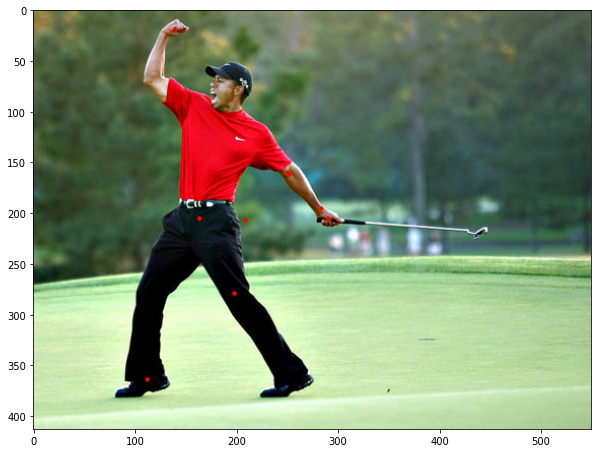

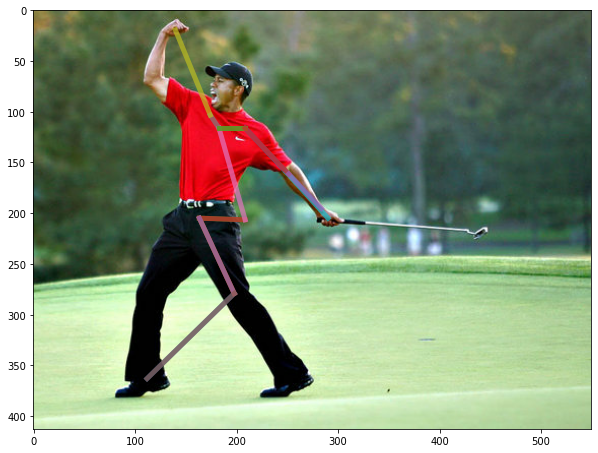

In [57]:
#결과 이미지


image, keypoints = predict('./test_image.jpg')
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)